In [1]:
#####
###
##
#
#   PROJECT DETAILS HERE
#
##
###
#####

### SETTINGS
##
# Dependencies
import requests
import json
import pandas as pd
from datetime import date

asset_id_base = 'BTC'
limit = 100

# API Keys
# Daily limits apply, make sure to only use 1
#apikey_coinapi = 'B44F0242-E0BA-4C1A-BED2-831A67426480'
#apikey_coinapi = '1830D89F-A633-4F73-9707-3A7FAFE5C0F0'
apikey_coinapi = '200EF4DD-8BF3-4A8A-9FC9-CF9C9D6D1173'

In [2]:
# # Download the list of assets

# # #Assets

# # https://docs.coinapi.io/#list-all-assets
# url = 'https://rest.coinapi.io/v1/assets'
# headers = { 'X-CoinAPI-Key' : 'B44F0242-E0BA-4C1A-BED2-831A67426480' }
# response = requests.get(url, headers=headers)

# with open( 'data_raw/assets.json', 'w' ) as ii:
#     json.dump( response.json(), ii )

In [3]:
#load downloaded asset list to pandas frame
with open( 'data_raw/assets.json', 'r' ) as jj:
    json_d = json.load( jj )
    df_assets = pd.DataFrame( json_d )

In [4]:
df_assets.head(3)

,asset_id,name,type_is_crypto,data_start,data_end,data_quote_start,data_quote_end,data_orderbook_start,data_orderbook_end,data_trade_start,data_trade_end,data_symbols_count,volume_1hrs_usd,volume_1day_usd,volume_1mth_usd,price_usd,id_icon
0,BTC,Bitcoin,1,2010-07-17,2021-02-08,2014-02-24T17:43:05.0000000Z,2021-02-08T08:34:49.1645002Z,2014-02-24T17:43:05.0000000Z,2020-08-05T14:38:38.3413202Z,2010-07-17T23:09:17.0000000Z,2021-02-08T10:13:31.0000000Z,47678,9.060663e+12,3.153321e+14,1.315314e+16,39186.174251,4caf2b16-a017-4e26-a348-2cea69c34cba
1,USD,US Dollar,0,2010-07-17,2021-02-08,2014-02-24T17:43:05.0000000Z,2021-02-08T08:33:53.1400325Z,2014-02-24T17:43:05.0000000Z,2020-08-05T14:38:00.7082850Z,2010-07-17T23:09:17.0000000Z,2021-02-08T08:34:42.4730000Z,43055,9.283904e+12,3.214332e+14,1.327275e+16,NaN,0a4185f2-1a03-4a7c-b866-ba7076d8c73b
2,PLN,Zloty,0,2011-04-05,2021-02-08,2017-08-29T15:47:10.0528025Z,2021-02-08T08:33:28.7770000Z,2017-08-29T15:47:10.0528025Z,2020-08-05T14:37:41.6530000Z,2011-04-05T18:49:48.0000000Z,2021-02-08T08:34:29.5840000Z,57,3.719296e+06,5.076524e+07,2.562955e+09,0.266961,3f682b5b-77ec-4d8c-b612-b8ff3ac748f7


In [5]:
#show only assets that are crypto
df_assets.loc[df_assets['type_is_crypto'] == 1].head(5)

,asset_id,name,type_is_crypto,data_start,data_end,data_quote_start,data_quote_end,data_orderbook_start,data_orderbook_end,data_trade_start,data_trade_end,data_symbols_count,volume_1hrs_usd,volume_1day_usd,volume_1mth_usd,price_usd,id_icon
0,BTC,Bitcoin,1,2010-07-17,2021-02-08,2014-02-24T17:43:05.0000000Z,2021-02-08T08:34:49.1645002Z,2014-02-24T17:43:05.0000000Z,2020-08-05T14:38:38.3413202Z,2010-07-17T23:09:17.0000000Z,2021-02-08T10:13:31.0000000Z,47678,9.060663e+12,3.153321e+14,1.315314e+16,39186.174251,4caf2b16-a017-4e26-a348-2cea69c34cba
17,NIS,NIS,1,2013-03-15,2021-02-08,2018-01-24T00:42:50.1443495Z,2021-02-08T08:27:33.3199822Z,2018-01-24T00:42:50.1443495Z,2020-08-05T14:37:37.8190850Z,2013-03-15T12:48:43.0000000Z,2020-06-25T13:09:04.0000000Z,8,0.000000e+00,0.000000e+00,0.000000e+00,0.289939,NaN
18,LTC,Litecoin,1,2013-05-19,2021-02-08,2014-04-20T15:06:34.0000000Z,2021-02-08T08:33:59.5351489Z,2014-04-20T15:06:34.0000000Z,2020-08-05T14:37:59.4868435Z,2013-05-19T15:23:45.0000000Z,2021-02-08T08:34:38.3580000Z,4022,3.744373e+09,1.109785e+11,3.925387e+12,152.148505,a201762f-1499-41ef-9b84-e0742cd00e48
20,VEN,VeChain (pre-swap),1,2013-10-22,2021-02-08,2014-07-31T13:05:46.0000000Z,2021-02-08T08:32:23.6146926Z,2014-07-31T13:05:46.0000000Z,2020-08-05T14:37:58.3010000Z,2013-10-22T23:09:46.8630000Z,2021-02-08T08:32:38.3330000Z,131,2.484975e+06,8.811079e+07,3.465864e+09,0.030039,99d66a67-9bdc-4b85-84ac-2a23f912b398
21,XRP,Ripple,1,2013-11-25,2021-02-08,2014-07-31T13:05:46.0000000Z,2021-02-08T08:34:03.9960603Z,2014-07-31T13:05:46.0000000Z,2020-08-05T14:37:58.7010000Z,2013-11-25T11:54:57.9270000Z,2021-02-08T08:34:18.5383130Z,1758,1.231453e+08,4.606453e+09,2.148420e+11,0.429193,ba90bcb0-cafb-4801-ac5d-d310f47d6411


In [6]:
df_assets.loc[df_assets['asset_id'] == asset_id_base, ['asset_id', 'name', 'type_is_crypto', 'price_usd', 'data_start', 'data_end', 'data_symbols_count', 'volume_1hrs_usd', 'volume_1day_usd', 'volume_1mth_usd']]

,asset_id,name,type_is_crypto,price_usd,data_start,data_end,data_symbols_count,volume_1hrs_usd,volume_1day_usd,volume_1mth_usd
0,BTC,Bitcoin,1,39186.174251,2010-07-17,2021-02-08,47678,9.060663e+12,3.153321e+14,1.315314e+16


In [7]:
#record # of days data available, vs, total amount of data available
#can be used on webpage to show % complete information
#also to show rough number of API calls used (100 results = 1 call)

# date_start = df_assets[df_assets['asset_id'] == asset_id_base]['data_start']

# today = date.today()

# print(f'{asset_id_base} Data Start: {date_start.iloc[0]}, Today: {today}')
# print(f'Number of Days: {(today - date_start.iloc[0]).days}')
# #print(f'Approx # of API calls to calculate: { (today - date_start.iloc[0])/100 }')

# print(date_start.iloc[0])

In [8]:
#check USD > AUD conversion rate
df_assets.loc[df_assets['asset_id'] == 'AUD', ['asset_id', 'name', 'type_is_crypto', 'data_end', 'price_usd']]

,asset_id,name,type_is_crypto,data_end,price_usd
6,AUD,Australian Dollar,0,2021-02-08,0.761895


In [9]:
#get historical data, starting from beginning date in 'assets.json' for particular asset
#asset_id_base = 'LTC'
asset_id_quote = 'USD'
time_start = df_assets[df_assets['asset_id'] == asset_id_base]['data_start']
period_id = '1DAY'
endpoint = 'https://rest.coinapi.io'
#limit = 3
include_empty_items = False


# furl = f"{endpoint}/v1/ohlcv/{asset_id_base}/{asset_id_quote}/history?period_id={period_id}&time_start={time_start.iloc[0]}&limit={limit}&include_empty_items={include_empty_items}"

# url = furl
# headers = {'X-CoinAPI-Key' : apikey_coinapi }
# response = requests.get(url, headers=headers)

# display(f'{response}')

# #save to asset_id_base.json
# with open( f'data_raw/{asset_id_base}.json', 'w' ) as ii:
#     json.dump( response.json(), ii )

In [10]:
#open and save it to a dataframe
with open( f'data_raw/{asset_id_base}.json', 'r' ) as jj:
    json_d = json.load( jj )
    df_asset_id = pd.DataFrame( json_d )
df_asset_id

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2011-09-13T00:00:00.0000000Z,2011-09-14T00:00:00.0000000Z,2011-09-13T13:53:36.0000000Z,2011-09-13T19:34:36.0000000Z,5.80,6.00,5.65,5.97,58.371382,12
1,2011-09-14T00:00:00.0000000Z,2011-09-15T00:00:00.0000000Z,2011-09-14T07:00:00.0000000Z,2011-09-14T15:42:31.0000000Z,5.58,5.72,5.52,5.53,61.145984,14
2,2011-09-15T00:00:00.0000000Z,2011-09-16T00:00:00.0000000Z,2011-09-15T08:39:33.0000000Z,2011-09-15T15:11:22.0000000Z,5.12,5.24,5.00,5.13,80.140795,6
3,2011-09-16T00:00:00.0000000Z,2011-09-17T00:00:00.0000000Z,2011-09-16T07:02:06.0000000Z,2011-09-16T16:13:02.0000000Z,4.82,4.87,4.80,4.85,39.914007,4
4,2011-09-17T00:00:00.0000000Z,2011-09-18T00:00:00.0000000Z,2011-09-17T15:32:08.0000000Z,2011-09-17T15:32:08.0000000Z,4.87,4.87,4.87,4.87,0.300000,1
...,...,...,...,...,...,...,...,...,...,...
3414,2021-02-04T00:00:00.0000000Z,2021-02-05T00:00:00.0000000Z,2021-02-04T00:00:00.2246000Z,2021-02-04T23:59:59.9351240Z,37688.42,38785.99,36156.45,36975.00,53539.376326,500954
3415,2021-02-05T00:00:00.0000000Z,2021-02-06T00:00:00.0000000Z,2021-02-05T00:00:00.0010000Z,2021-02-05T23:59:59.9134880Z,36975.80,38388.76,36582.90,38311.49,29467.042208,374809
3416,2021-02-06T00:00:00.0000000Z,2021-02-07T00:00:00.0000000Z,2021-02-06T00:00:00.0090000Z,2021-02-06T23:59:59.5270000Z,38311.70,41025.48,38221.40,39257.00,47185.230849,477863
3417,2021-02-07T00:00:00.0000000Z,2021-02-08T00:00:00.0000000Z,2021-02-07T00:00:00.0780000Z,2021-02-07T23:59:59.9918780Z,39257.00,39748.96,37371.35,38871.42,32903.679813,373241


In [ ]:
#get new start time from time period end
#note this should be done using the json format instead of pandas, cuts out extra step
#json_d[-1]["price_close"]

time_start = df_asset_id['time_period_end'].iloc[-1]
furl = f"{endpoint}/v1/ohlcv/{asset_id_base}/{asset_id_quote}/history?period_id={period_id}&time_start={time_start}&limit={limit}&include_empty_items={include_empty_items}"

url = furl
headers = {'X-CoinAPI-Key' : apikey_coinapi }
response = requests.get(url, headers=headers)

In [ ]:
response.json()

In [ ]:
with open( f'data_raw/{asset_id_base}.json', 'r+' ) as ii:
    json_d = json.load( ii )
    
    json_d.extend(response.json())
    ii.seek(0)
    
    json.dump(json_d, ii)

In [11]:
with open( f'data_raw/{asset_id_base}.json', 'r' ) as jj:
    json_d = json.load( jj )
    df_asset_id = pd.DataFrame( json_d )
display(f'OHCLV Data for {asset_id_base} - {df_assets.iloc[df_assets.loc[df_assets["asset_id"] == asset_id_base].index.item()]["name"]}')
display(df_asset_id)

'OHCLV Data for BTC - Bitcoin'

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2011-09-13T00:00:00.0000000Z,2011-09-14T00:00:00.0000000Z,2011-09-13T13:53:36.0000000Z,2011-09-13T19:34:36.0000000Z,5.80,6.00,5.65,5.97,58.371382,12
1,2011-09-14T00:00:00.0000000Z,2011-09-15T00:00:00.0000000Z,2011-09-14T07:00:00.0000000Z,2011-09-14T15:42:31.0000000Z,5.58,5.72,5.52,5.53,61.145984,14
2,2011-09-15T00:00:00.0000000Z,2011-09-16T00:00:00.0000000Z,2011-09-15T08:39:33.0000000Z,2011-09-15T15:11:22.0000000Z,5.12,5.24,5.00,5.13,80.140795,6
3,2011-09-16T00:00:00.0000000Z,2011-09-17T00:00:00.0000000Z,2011-09-16T07:02:06.0000000Z,2011-09-16T16:13:02.0000000Z,4.82,4.87,4.80,4.85,39.914007,4
4,2011-09-17T00:00:00.0000000Z,2011-09-18T00:00:00.0000000Z,2011-09-17T15:32:08.0000000Z,2011-09-17T15:32:08.0000000Z,4.87,4.87,4.87,4.87,0.300000,1
...,...,...,...,...,...,...,...,...,...,...
3414,2021-02-04T00:00:00.0000000Z,2021-02-05T00:00:00.0000000Z,2021-02-04T00:00:00.2246000Z,2021-02-04T23:59:59.9351240Z,37688.42,38785.99,36156.45,36975.00,53539.376326,500954
3415,2021-02-05T00:00:00.0000000Z,2021-02-06T00:00:00.0000000Z,2021-02-05T00:00:00.0010000Z,2021-02-05T23:59:59.9134880Z,36975.80,38388.76,36582.90,38311.49,29467.042208,374809
3416,2021-02-06T00:00:00.0000000Z,2021-02-07T00:00:00.0000000Z,2021-02-06T00:00:00.0090000Z,2021-02-06T23:59:59.5270000Z,38311.70,41025.48,38221.40,39257.00,47185.230849,477863
3417,2021-02-07T00:00:00.0000000Z,2021-02-08T00:00:00.0000000Z,2021-02-07T00:00:00.0780000Z,2021-02-07T23:59:59.9918780Z,39257.00,39748.96,37371.35,38871.42,32903.679813,373241


In [12]:
df_asset_id.nunique()

time_period_start    3419
time_period_end      3419
time_open            3419
time_close           3419
price_open           3228
price_high           3133
price_low            3135
price_close          3223
volume_traded        3418
trades_count         3137
dtype: int64

In [13]:
# with open( f'data_raw/{asset_id_base}.json', 'r' ) as jj:
#     json_d = json.load( jj )
# print(json.dumps(json_d, indent=4))

In [78]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
#import requests
# import jsonquote = 'AAPL'

# days = 300def candlestick(quote,days):
#   r = requests.get(f’https://financialmodelingprep.com/api/v3/historical-price-full/{quote}?timeseries={days}')
#   r = r.json()

with open(f'data_raw/{asset_id_base}.json', 'r') as jj:
    r = json.load(jj)

stockdata = r
stockdata_df = pd.DataFrame(stockdata)

fig = go.Figure(data=[go.Candlestick(
    x=stockdata_df['time_period_start'],
    open=stockdata_df['price_open'],
    high=stockdata_df['price_high'],
    low=stockdata_df['price_low'],
    close=stockdata_df['price_close'])])

fig.update_layout(
    title={'text': f'{asset_id_base} in ${asset_id_quote}',
           'y': 0.9,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
)

fig.show()

In [79]:
######MACHINE LEARNING
#########
#########
#########
#########

hist ={}




import json
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [113]:
hist = stockdata_df[['time_period_end', 'price_close', 'price_high', 'price_low', 'price_open', 'volume_traded']]

#hist['time_period_end'] = hist['time_period_end'][0].split("T", 1)[0]

hist['time_period_end'] = hist['time_period_end'].apply(lambda x: x.split("T", 1)[0])

#hist['time_period_end'] = pd.to_datetime(hist['time_period_end'])

hist.set_index(['time_period_end'], inplace=True)

#hist.index = pd.to_datetime(hist.index, unit='s')

target_col = 'price_close'

hist



<ipython-input-113-5d207ed63aa1>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,price_close,price_high,price_low,price_open,volume_traded
time_period_end,,,,,
2011-09-14,5.97,6.00,5.65,5.80,58.371382
2011-09-15,5.53,5.72,5.52,5.58,61.145984
2011-09-16,5.13,5.24,5.00,5.12,80.140795
2011-09-17,4.85,4.87,4.80,4.82,39.914007
2011-09-18,4.87,4.87,4.87,4.87,0.300000
...,...,...,...,...,...
2021-02-05,36975.00,38785.99,36156.45,37688.42,53539.376326
2021-02-06,38311.49,38388.76,36582.90,36975.80,29467.042208
2021-02-07,39257.00,41025.48,38221.40,38311.70,47185.230849


In [114]:
hist.dtypes

price_close      float64
price_high       float64
price_low        float64
price_open       float64
volume_traded    float64
dtype: object

In [115]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)

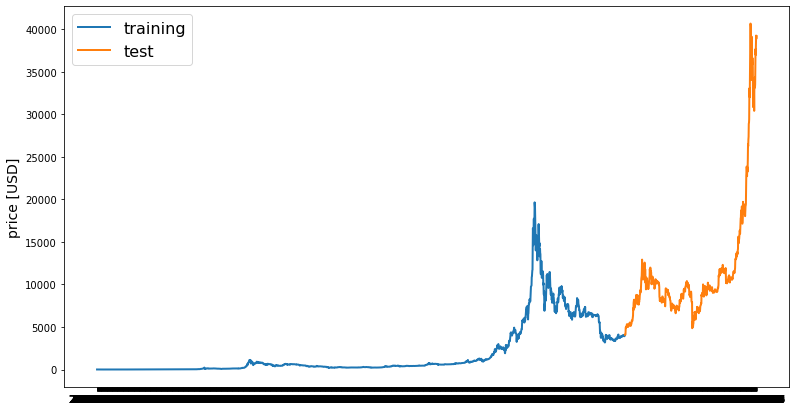

In [116]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [117]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [118]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [119]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [120]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [121]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [127]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [128]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_5/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)